# PSO Query Strategy

Particles fly around search space composed of image index within dataset. Each particles position corresponds to a specific index (image). 

## Cost Function

- PSO finds optimal image indexes to minimize the output of the cost function: 1 - Accuracy
- Accuracy is 0.0 <= Accuracy <= 1.0

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import load_iris
from alipy import ToolBox
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from random import sample 

## PSO Algorithm Class

In [15]:
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc,label_ind, unlab_ind, model=None, batch_size=1):
        self.err_i=costFunc(self.position_i,label_ind, unlab_ind, model=None, batch_size=1)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter,label_ind, unlab_ind, model=None, batch_size=1):
        global num_dimensions

        num_dimensions= len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc,label_ind, unlab_ind, model=None, batch_size=1)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        self.pos = pos_best_g
        self.cost = err_best_g
       

# Cost Function

Find image indexes in dataset to search for max accuracy within the search space 

 - Search Space Bounds: [0,50]
 - Dimensions = max images 
 - Initial x = random.sample(list(unlabeled), Dimensions)

In [25]:
def cost_function(x,label_ind, unlab_ind, model, batch_size=1):

    # Select a subset of Uind according to the query strategy
    # Passing model=None to use the default model for evaluating the committees' disagreement
    
    #Convert each x position to int
    x = [math.floor(element) for element in x]
    
    
    select_ind = []
    for index in range(0,len(x)):

        x_already_select.append(x[index])


    for index in range(0,len(x)):
        if x[index] not in x_already_select: 
            select_ind.append(x[index])
    
        
    
    label_ind.update(select_ind)
    unlab_ind.difference_update(select_ind)
    
    

    # Update model and calc performance according to the model you are using
    default_model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
    pred = default_model.predict(X[test_idx, :])
    accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')
        
    
    return 1 - accuracy

# Run PSO Strategy on sklearn IRIS Dataset

Number of Images Selected:  10
Round:  0    Accuracy: 0.6888888888888889

Number of Images Selected:  10
Round:  1    Accuracy: 0.9111111111111111

Number of Images Selected:  10
Round:  2    Accuracy: 0.9333333333333333

Number of Images Selected:  10
Round:  3    Accuracy: 0.8222222222222222

Number of Images Selected:  10
Round:  4    Accuracy: 0.7333333333333333

Number of Images Selected:  10
Round:  5    Accuracy: 0.7555555555555555

Number of Images Selected:  10
Round:  6    Accuracy: 0.8444444444444444

Number of Images Selected:  10
Round:  7    Accuracy: 0.6888888888888889

Number of Images Selected:  10
Round:  8    Accuracy: 0.9777777777777777

Number of Images Selected:  10
Round:  9    Accuracy: 0.6



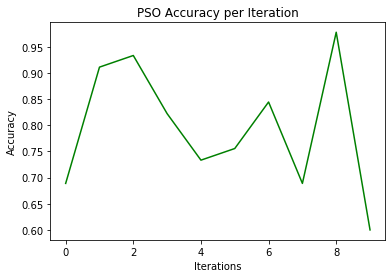

In [28]:

# load in IRIS dataset
X, y = load_iris(return_X_y=True)
alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path='.')

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=10)

# Use the default Logistic Regression classifier
default_model = alibox.get_default_model()

# Store accuracy at each iteration
accuracy_result = []

iterations = 10


for round in range(iterations):
    
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    #Initialize swarm parameters
    dims = 10
    x_min = 0
    x_max = len(unlab_ind)
    initial = []
    bounds=[]  

    initial = sample(list(unlab_ind), dims)
    x_already_select = initial

    for dims in range(0,dims):
        bounds.append((x_min,x_max))
        
        
        
    # Select a subset of Uind according to the PSO strategy
    PSO_object = PSO(cost_function,initial,bounds,num_particles=30,maxiter=30,label_ind=label_ind, unlab_ind=unlab_ind, model=default_model, batch_size=1)

    select_ind = []
    for index in range(0,len(PSO_object.pos)):
        select_ind.append(PSO_object.pos[index])
    
    print("Number of Images Selected: ", len(select_ind))

    #Update unlabeled and labeled dataset
    label_ind.update(select_ind)
    unlab_ind.difference_update(select_ind)



    # Update model and calc performance according to the model you are using
    default_model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
    pred = default_model.predict(X[test_idx, :])
    accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')
    
    
    print("Round: ", round, "   Accuracy:",accuracy)
    print()
    accuracy_result.append(accuracy)





x = list(range(iterations))
plt.plot(x,accuracy_result,color='g')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('PSO Accuracy per Iteration')
plt.show()
